In [1]:
import os
import time
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Parse the dataset

In [3]:
base_dir1 = r"D:\Datasets\Voxceleb1\wav1"  # modify it to your own dir
base_dir2 = r"D:\Datasets\Voxceleb1\wav2"  # modify it to your own dir
# base_dir3 = r"D:\Datasets\Voxceleb1\vox1_test_wav"  # we don't use testing data

def get_audio_file_paths(base_dir):
    audio_files = []
    for speaker_id in os.listdir(base_dir):
        speaker_dir = os.path.join(base_dir, speaker_id)
        if os.path.isdir(speaker_dir):
            for video_id in os.listdir(speaker_dir):
                video_dir = os.path.join(speaker_dir, video_id)
                if os.path.isdir(video_dir):
                    for file in os.listdir(video_dir):
                        if file.endswith('.wav'):
                            audio_files.append({
                                "speaker_id": speaker_id,
                                "video_id": video_id,
                                "file_path": os.path.join(video_dir, file)
                            })
    return audio_files

audio_files = []
audio_files = audio_files + get_audio_file_paths(base_dir1)
audio_files = audio_files + get_audio_file_paths(base_dir2)
# audio_files = audio_files + get_audio_file_paths(base_dir3)
audio_df = pd.DataFrame(audio_files)
print(audio_df.head())


  speaker_id     video_id                                          file_path
0    id10001  1zcIwhmdeo4  D:\Datasets\Voxceleb1\wav1\id10001\1zcIwhmdeo4...
1    id10001  1zcIwhmdeo4  D:\Datasets\Voxceleb1\wav1\id10001\1zcIwhmdeo4...
2    id10001  1zcIwhmdeo4  D:\Datasets\Voxceleb1\wav1\id10001\1zcIwhmdeo4...
3    id10001  7gWzIy6yIIk  D:\Datasets\Voxceleb1\wav1\id10001\7gWzIy6yIIk...
4    id10001  7gWzIy6yIIk  D:\Datasets\Voxceleb1\wav1\id10001\7gWzIy6yIIk...


## Extracting Audio Features

In [4]:
def extract_features(file_path, sr=16000, n_mfcc=13):
    try:
        y, sr = librosa.load(file_path, sr=sr)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        zcr = librosa.feature.zero_crossing_rate(y)
        rmse = librosa.feature.rms(y=y)
        features = np.hstack([
            mfccs.mean(axis=1),
            zcr.mean(axis=1),
            rmse.mean(axis=1)
        ])
        return features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

start = time.time()
sample_features = extract_features(audio_df['file_path'].iloc[0])
print("Sample Features:", sample_features)
print(f"Time: {time.time()-start}s")


Sample Features: [-1.23067284e+02  6.75206223e+01 -8.46449947e+00  3.10433998e+01
 -1.44772911e+01 -1.15791302e+01 -2.31099567e+01 -1.54118614e+01
  9.38481390e-01 -8.89546204e+00 -5.52941132e+00 -1.74579823e+00
 -9.12474442e+00  1.66613481e-01  8.24284106e-02]
Time: 6.724243640899658s


## Dataset Split w.r.t. Videos of a Person

In [5]:
from sklearn.model_selection import train_test_split

grouped = audio_df.groupby('speaker_id')

train_files = []
val_files = []

random_state = 42

for speaker_id, group in grouped:
    video_ids = group['video_id'].unique()
    train_videos, val_videos = train_test_split(video_ids, test_size=0.2, random_state=random_state)
    train_files.extend(group[group['video_id'].isin(train_videos)]['file_path'].tolist())
    val_files.extend(group[group['video_id'].isin(val_videos)]['file_path'].tolist())

print(f"Number of training files: {len(train_files)}")
print(f"Number of validation files: {len(val_files)}")


Number of training files: 114674
Number of validation files: 33968


In [6]:
train_features = []
train_labels = []

print('Begin to extracting training set features...')
for i, file_path in enumerate(train_files):
    if i % 1000 == 0:
        print('Extracting feature of sample', i)
    feature = extract_features(file_path)
    if feature is not None:
        train_features.append(feature)
        speaker_id = os.path.basename(os.path.dirname(os.path.dirname(file_path)))
        train_labels.append(speaker_id)

val_features = []
val_labels = []

print('Begin to extracting validation set features...')
for i, file_path in enumerate(val_files):
    if i % 1000 == 0:
        print('Extracting feature of sample', i)
    feature = extract_features(file_path)
    if feature is not None:
        val_features.append(feature)
        speaker_id = os.path.basename(os.path.dirname(os.path.dirname(file_path)))
        val_labels.append(speaker_id)

X_train = np.array(train_features)
y_train = np.array(train_labels)
X_val = np.array(val_features)
y_val = np.array(val_labels)

print("Training set features shape:", X_train.shape)
print("Validation set features shape:", X_val.shape)


Begin to extracting training set features...
Extracting feature of sample 0
Extracting feature of sample 1000
Extracting feature of sample 2000
Extracting feature of sample 3000
Extracting feature of sample 4000
Extracting feature of sample 5000
Extracting feature of sample 6000
Extracting feature of sample 7000
Extracting feature of sample 8000
Extracting feature of sample 9000
Extracting feature of sample 10000
Extracting feature of sample 11000
Extracting feature of sample 12000
Extracting feature of sample 13000
Extracting feature of sample 14000
Extracting feature of sample 15000
Extracting feature of sample 16000
Extracting feature of sample 17000
Extracting feature of sample 18000
Extracting feature of sample 19000
Extracting feature of sample 20000
Extracting feature of sample 21000
Extracting feature of sample 22000
Extracting feature of sample 23000
Extracting feature of sample 24000
Extracting feature of sample 25000
Extracting feature of sample 26000
Extracting feature of s

In [8]:
np.savez('voxceleb1_grouped_features.npz', X_train=X_train, X_val=X_val, y_train=y_train, y_val=y_val)

In [7]:
train_speakers = set(y_train)
val_speakers = set(y_val)

print(f"Number of unique speakers in training set: {len(train_speakers)}")
print(f"Number of unique speakers in validation set: {len(val_speakers)}")

if train_speakers != val_speakers:
    print("Warning: Train and validation sets do not contain the same speakers!")
else:
    print("Train and validation sets contain the same speakers.")

Number of unique speakers in training set: 1211
Number of unique speakers in validation set: 1211
Train and validation sets contain the same speakers.


In [9]:
data = np.load('voxceleb1_grouped_features.npz')

X_train = data['X_train']
X_val = data['X_val']
y_train = data['y_train']
y_val = data['y_val']

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: (114674, 15)
X_val shape: (33968, 15)
y_train shape: (114674,)
y_val shape: (33968,)


### Sample 200 speakers

In [22]:
import numpy as np

# Sample the first 200 speakers
def sample_first_n_speakers(X, y, n=200):
    # Get unique speaker IDs and select the first `n`
    unique_speakers = np.unique(y)
    selected_speakers = unique_speakers[:n]
    print(selected_speakers)
    
    # Filter the data for selected speakers
    mask = np.isin(y, selected_speakers)
    X_sampled = X[mask]
    y_sampled = y[mask]
    
    return X_sampled, y_sampled

# Apply sampling to training and validation sets
X_train_sampled, y_train_sampled = sample_first_n_speakers(X_train, y_train, n=200)
X_val_sampled, y_val_sampled = sample_first_n_speakers(X_val, y_val, n=200)

# Map labels to a range of 0 to n-1 to avoid label value errors
def remap_labels(y):
    unique_labels = np.unique(y)
    label_map = {old: new for new, old in enumerate(unique_labels)}
    y_remapped = np.array([label_map[label] for label in y])
    return y_remapped

y_train_sampled = remap_labels(y_train_sampled)
y_val_sampled = remap_labels(y_val_sampled)

# Print dataset shapes after sampling
print(f"X_train_sampled shape: {X_train_sampled.shape}")
print(f"y_train_sampled shape: {y_train_sampled.shape}")
print(f"X_val_sampled shape: {X_val_sampled.shape}")
print(f"y_val_sampled shape: {y_val_sampled.shape}")


['id10001' 'id10002' 'id10003' 'id10004' 'id10005' 'id10006' 'id10007'
 'id10008' 'id10009' 'id10010' 'id10011' 'id10012' 'id10013' 'id10014'
 'id10015' 'id10016' 'id10017' 'id10018' 'id10019' 'id10020' 'id10021'
 'id10022' 'id10023' 'id10024' 'id10025' 'id10026' 'id10027' 'id10028'
 'id10029' 'id10030' 'id10031' 'id10032' 'id10033' 'id10034' 'id10035'
 'id10036' 'id10037' 'id10038' 'id10039' 'id10040' 'id10041' 'id10042'
 'id10043' 'id10044' 'id10045' 'id10046' 'id10047' 'id10048' 'id10049'
 'id10050' 'id10051' 'id10052' 'id10053' 'id10054' 'id10055' 'id10056'
 'id10057' 'id10058' 'id10059' 'id10060' 'id10061' 'id10062' 'id10063'
 'id10064' 'id10065' 'id10066' 'id10067' 'id10068' 'id10069' 'id10070'
 'id10071' 'id10072' 'id10073' 'id10074' 'id10075' 'id10076' 'id10077'
 'id10078' 'id10079' 'id10080' 'id10081' 'id10082' 'id10083' 'id10084'
 'id10085' 'id10086' 'id10087' 'id10088' 'id10089' 'id10090' 'id10091'
 'id10092' 'id10093' 'id10094' 'id10095' 'id10096' 'id10097' 'id10098'
 'id10

In [21]:
y_val_encoded

array([  0,   0,   0, ..., 199, 199, 199], dtype=int64)

# Build MLP Model

In [11]:
class SmallNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SmallNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class MediumNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MediumNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

class LargeNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LargeNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(256, 128)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.fc4(x)
        return x

In [12]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_sampled)
y_val_encoded = label_encoder.transform(y_val_sampled)

train_dataset = TensorDataset(torch.tensor(X_train_sampled, dtype=torch.float32), torch.tensor(y_train_encoded, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val_sampled, dtype=torch.float32), torch.tensor(y_val_encoded, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001, print_every=100):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Lists to store metrics for plotting
    training_loss_list = []
    training_accuracy_list = []
    validation_loss_list = []
    validation_accuracy_list = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for i, (X_batch, y_batch) in enumerate(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

            # Print metrics every n iterations
            if (i + 1) % print_every == 0:
                avg_loss = total_loss / (i + 1)
                accuracy = correct / total
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], "
                      f"Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

        # Store training metrics for this epoch
        training_loss_list.append(total_loss / len(train_loader))
        training_accuracy_list.append(correct / total)

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += y_batch.size(0)
                val_correct += (predicted == y_batch).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = val_correct / val_total
        validation_loss_list.append(avg_val_loss)
        validation_accuracy_list.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {training_loss_list[-1]:.4f}, "
              f"Training Accuracy: {training_accuracy_list[-1]:.4f}, "
              f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    return {
        "training_loss": training_loss_list,
        "training_accuracy": training_accuracy_list,
        "validation_loss": validation_loss_list,
        "validation_accuracy": validation_accuracy_list,
    }


Epoch [1/30], Step [100/575], Loss: 14.8224, Accuracy: 0.0244
Epoch [1/30], Step [200/575], Loss: 10.6458, Accuracy: 0.0455
Epoch [1/30], Step [300/575], Loss: 8.9838, Accuracy: 0.0668
Epoch [1/30], Step [400/575], Loss: 7.9898, Accuracy: 0.0841
Epoch [1/30], Step [500/575], Loss: 7.3150, Accuracy: 0.1021
Epoch [1/30], Training Loss: 6.9376, Training Accuracy: 0.1121, Validation Loss: 5.6755, Validation Accuracy: 0.1241
Epoch [2/30], Step [100/575], Loss: 3.9875, Accuracy: 0.2219
Epoch [2/30], Step [200/575], Loss: 3.9141, Accuracy: 0.2275
Epoch [2/30], Step [300/575], Loss: 3.8495, Accuracy: 0.2349
Epoch [2/30], Step [400/575], Loss: 3.7516, Accuracy: 0.2447
Epoch [2/30], Step [500/575], Loss: 3.6815, Accuracy: 0.2517
Epoch [2/30], Training Loss: 3.6180, Training Accuracy: 0.2591, Validation Loss: 4.9068, Validation Accuracy: 0.1455
Epoch [3/30], Step [100/575], Loss: 3.0448, Accuracy: 0.3187
Epoch [3/30], Step [200/575], Loss: 3.0264, Accuracy: 0.3267
Epoch [3/30], Step [300/575], Lo

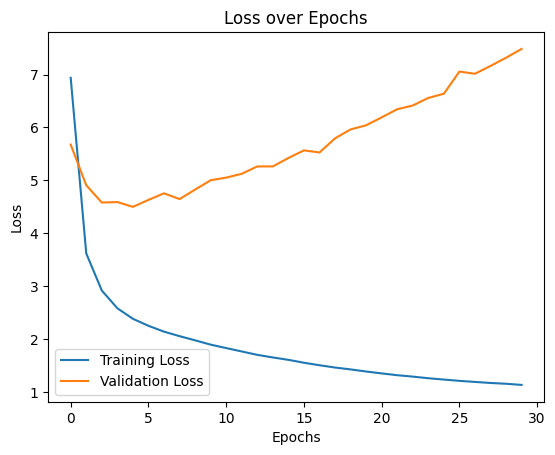

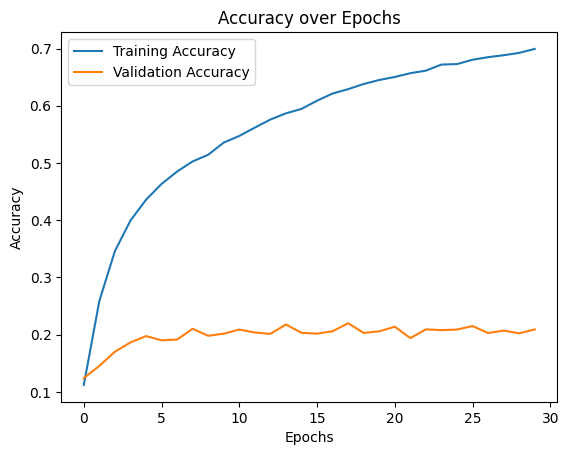

In [15]:
# Train the model and get metrics
model = SmallNet(input_size=15, num_classes=200)
metrics = train_model(model, train_loader, val_loader, num_epochs=30, print_every=100)

plt.figure()
plt.plot(metrics["training_loss"], label="Training Loss")
plt.plot(metrics["validation_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Plot training and validation accuracy
plt.figure()
plt.plot(metrics["training_accuracy"], label="Training Accuracy")
plt.plot(metrics["validation_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()


Epoch [1/30], Step [100/575], Loss: 6.0098, Accuracy: 0.0303
Epoch [1/30], Step [200/575], Loss: 5.4666, Accuracy: 0.0423
Epoch [1/30], Step [300/575], Loss: 5.2420, Accuracy: 0.0488
Epoch [1/30], Step [400/575], Loss: 5.0976, Accuracy: 0.0559
Epoch [1/30], Step [500/575], Loss: 4.9791, Accuracy: 0.0645
Epoch [1/30], Training Loss: 4.9075, Training Accuracy: 0.0695, Validation Loss: 4.8132, Validation Accuracy: 0.0811
Epoch [2/30], Step [100/575], Loss: 4.3396, Accuracy: 0.1156
Epoch [2/30], Step [200/575], Loss: 4.3131, Accuracy: 0.1231
Epoch [2/30], Step [300/575], Loss: 4.2714, Accuracy: 0.1273
Epoch [2/30], Step [400/575], Loss: 4.2444, Accuracy: 0.1291
Epoch [2/30], Step [500/575], Loss: 4.2072, Accuracy: 0.1326
Epoch [2/30], Training Loss: 4.1840, Training Accuracy: 0.1328, Validation Loss: 4.5777, Validation Accuracy: 0.0933
Epoch [3/30], Step [100/575], Loss: 3.9340, Accuracy: 0.1491
Epoch [3/30], Step [200/575], Loss: 3.8873, Accuracy: 0.1570
Epoch [3/30], Step [300/575], Loss

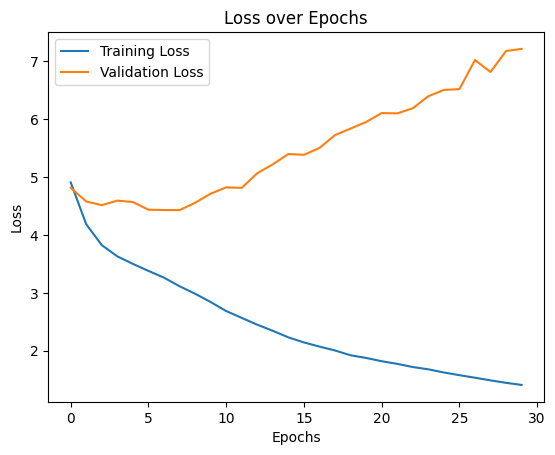

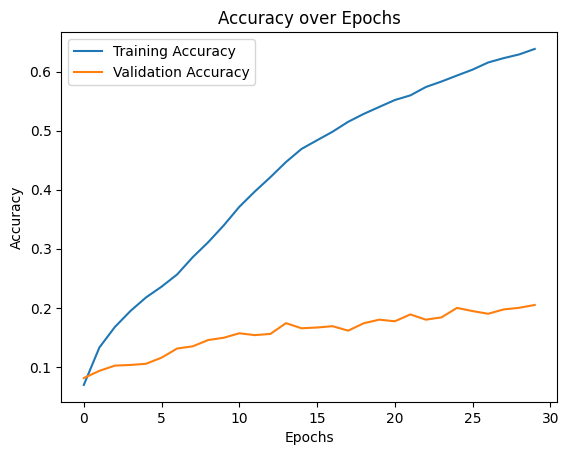

In [17]:
# Train the model and get metrics
model = MediumNet(input_size=15, num_classes=200)
metrics = train_model(model, train_loader, val_loader, num_epochs=30, print_every=100)

plt.figure()
plt.plot(metrics["training_loss"], label="Training Loss")
plt.plot(metrics["validation_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Plot training and validation accuracy
plt.figure()
plt.plot(metrics["training_accuracy"], label="Training Accuracy")
plt.plot(metrics["validation_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()


Epoch [1/30], Step [100/575], Loss: 5.4039, Accuracy: 0.0159
Epoch [1/30], Step [200/575], Loss: 5.2570, Accuracy: 0.0214
Epoch [1/30], Step [300/575], Loss: 5.1671, Accuracy: 0.0242
Epoch [1/30], Step [400/575], Loss: 5.1114, Accuracy: 0.0267
Epoch [1/30], Step [500/575], Loss: 5.0670, Accuracy: 0.0319
Epoch [1/30], Training Loss: 5.0341, Training Accuracy: 0.0357, Validation Loss: 5.0568, Validation Accuracy: 0.0631
Epoch [2/30], Step [100/575], Loss: 4.7946, Accuracy: 0.0612
Epoch [2/30], Step [200/575], Loss: 4.7759, Accuracy: 0.0639
Epoch [2/30], Step [300/575], Loss: 4.7737, Accuracy: 0.0617
Epoch [2/30], Step [400/575], Loss: 4.7565, Accuracy: 0.0609
Epoch [2/30], Step [500/575], Loss: 4.7153, Accuracy: 0.0636
Epoch [2/30], Training Loss: 4.6855, Training Accuracy: 0.0665, Validation Loss: 4.8885, Validation Accuracy: 0.0662
Epoch [3/30], Step [100/575], Loss: 4.4053, Accuracy: 0.0922
Epoch [3/30], Step [200/575], Loss: 4.3444, Accuracy: 0.0931
Epoch [3/30], Step [300/575], Loss

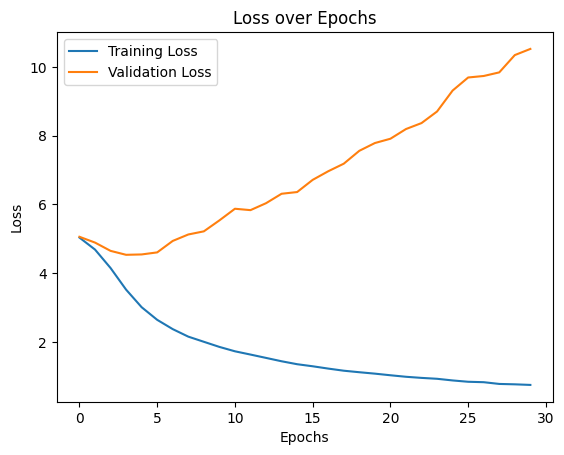

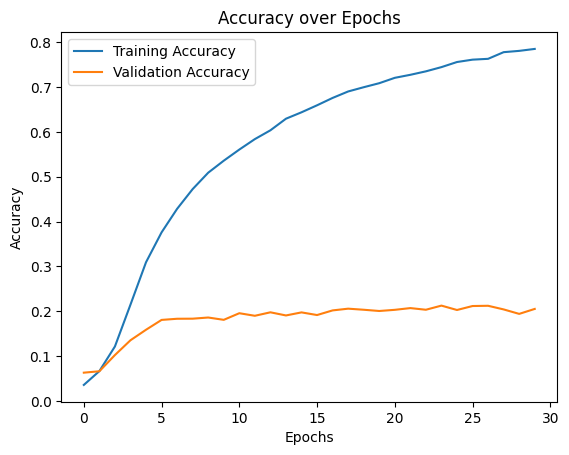

In [18]:
# Train the model and get metrics
model = LargeNet(input_size=15, num_classes=200)
metrics = train_model(model, train_loader, val_loader, num_epochs=30, print_every=100)

plt.figure()
plt.plot(metrics["training_loss"], label="Training Loss")
plt.plot(metrics["validation_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Plot training and validation accuracy
plt.figure()
plt.plot(metrics["training_accuracy"], label="Training Accuracy")
plt.plot(metrics["validation_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()


# Fine-tuning HuBert Model (too large, abandoned)

In [5]:
import torch
from transformers import HubertForSequenceClassification, Wav2Vec2Processor

# Load the HuBERT model and processor
model = HubertForSequenceClassification.from_pretrained(
    "facebook/hubert-large-ls960-ft",
    num_labels=1211  # Set to the number of speakers in your dataset
)
processor = Wav2Vec2Processor.from_pretrained("facebook/hubert-large-ls960-ft")

# Send model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at facebook/hubert-large-ls960-ft and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


HubertForSequenceClassification(
  (hubert): HubertModel(
    (feature_extractor): HubertFeatureEncoder(
      (conv_layers): ModuleList(
        (0): HubertLayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1-4): 4 x HubertLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (5-6): 2 x HubertLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): HubertFeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (pro

In [11]:
from torch.utils.data import Dataset, DataLoader
import torchaudio

class SpeakerDataset(Dataset):
    def __init__(self, file_paths, labels, processor, max_length=16000 * 10):
        self.file_paths = file_paths
        self.labels = labels
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Load raw audio waveform
        audio, sr = torchaudio.load(self.file_paths[idx])
        # Resample if necessary
        if sr != 16000:
            resample_transform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)
            audio = resample_transform(audio)
        audio = audio.squeeze(0)  # Remove channel dimension
        # Truncate or pad
        if len(audio) > self.max_length:
            audio = audio[:self.max_length]
        else:
            padding = self.max_length - len(audio)
            audio = torch.cat([audio, torch.zeros(padding)])
        # Process audio
        inputs = self.processor(audio.numpy(), sampling_rate=16000, return_tensors="pt", padding=True)
        # Return correct tensor shapes
        return {
            "input_values": inputs["input_values"].squeeze(0),  # Shape: (sequence_length,)
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Create Dataset and DataLoader
train_dataset = SpeakerDataset(train_files, y_train_encoded, processor)
val_dataset = SpeakerDataset(val_files, y_val_encoded, processor)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)


In [12]:
from transformers import AdamW
from torch.nn.functional import cross_entropy
from tqdm import tqdm

# Define optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Training loop
def train_hubert(model, train_loader, val_loader, epochs=3):
    train_loss_list, val_loss_list = [], []
    train_acc_list, val_acc_list = [], []

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss, correct, total = 0, 0, 0
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
            inputs = {key: value.to(device) for key, value in batch.items()}
            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = outputs.loss
            logits = outputs.logits
            loss.backward()
            optimizer.step()

            # Metrics
            train_loss += loss.item()
            preds = torch.argmax(logits, dim=-1)
            correct += (preds == inputs["labels"]).sum().item()
            total += len(inputs["labels"])

        train_loss_list.append(train_loss / len(train_loader))
        train_acc_list.append(correct / total)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: value.to(device) for key, value in batch.items()}
                outputs = model(**inputs)
                loss = outputs.loss
                logits = outputs.logits

                # Metrics
                val_loss += loss.item()
                preds = torch.argmax(logits, dim=-1)
                val_correct += (preds == inputs["labels"]).sum().item()
                val_total += len(inputs["labels"])

        val_loss_list.append(val_loss / len(val_loader))
        val_acc_list.append(val_correct / val_total)

        # Logging
        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Training Loss: {train_loss_list[-1]:.4f}, Training Accuracy: {train_acc_list[-1]:.4f}")
        print(f"Validation Loss: {val_loss_list[-1]:.4f}, Validation Accuracy: {val_acc_list[-1]:.4f}")

    return train_loss_list, val_loss_list, train_acc_list, val_acc_list

# Train the model
train_loss, val_loss, train_acc, val_acc = train_hubert(model, train_loader, val_loader, epochs=3)


C:\Applications\Anaconda3\envs\cv_course\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch 1/3:   0%|                                                        | 2/42362 [00:34<203:26:22, 17.29s/it]


KeyboardInterrupt: 

# Fine-tuning Wav2Vec Model

In [44]:
import torch
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2Processor

# Load the Wav2Vec2 model and processor
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "OthmaneJ/distil-wav2vec2",
    num_labels=200  # Number of speakers in your dataset
)
processor = Wav2Vec2Processor.from_pretrained("OthmaneJ/distil-wav2vec2")

# Send model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at OthmaneJ/distil-wav2vec2 and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)


In [46]:
from torch.utils.data import Dataset, DataLoader
import torchaudio

class SpeakerDataset(Dataset):
    def __init__(self, file_paths, labels, processor, max_length=16000 * 10):
        # Filter both 'data' and 'labels'
        filtered_data_labels = [(d, label) for d, label in zip(file_paths, labels) if 0 <= label < 200]
        
        # Separate the filtered data and labels
        filtered_data, filtered_labels = zip(*filtered_data_labels)
        
        # Convert back to lists
        self.file_paths = list(filtered_data)
        self.labels = list(filtered_labels)
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Load raw audio waveform
        audio, sr = torchaudio.load(self.file_paths[idx])
        # Resample if necessary
        if sr != 16000:
            resample_transform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)
            audio = resample_transform(audio)
        audio = audio.squeeze(0)  # Remove channel dimension
        # Truncate or pad
        if len(audio) > self.max_length:
            audio = audio[:self.max_length]
        else:
            padding = self.max_length - len(audio)
            audio = torch.cat([audio, torch.zeros(padding)])
        # Process audio
        inputs = self.processor(audio.numpy(), sampling_rate=16000, return_tensors="pt", padding=True)
        return {
            "input_values": inputs["input_values"].squeeze(0),  # Shape: (sequence_length,)
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Create Dataset and DataLoader
train_dataset = SpeakerDataset(train_files, y_train_encoded, processor)
val_dataset = SpeakerDataset(val_files, y_val_encoded, processor)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


In [47]:
from transformers import AdamW
from tqdm import tqdm

# Define optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Training loop
def train_wav2vec(model, train_loader, val_loader, epochs=3):
    train_loss_list, val_loss_list = [], []
    train_acc_list, val_acc_list = [], []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss, correct, total = 0, 0, 0
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
            inputs = {key: value.to(device) for key, value in batch.items()}
            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = outputs.loss
            logits = outputs.logits
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = torch.argmax(logits, dim=-1)
            correct += (preds == inputs["labels"]).sum().item()
            total += len(inputs["labels"])

        train_loss_list.append(train_loss / len(train_loader))
        train_acc_list.append(correct / total)

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: value.to(device) for key, value in batch.items()}
                outputs = model(**inputs)
                loss = outputs.loss
                logits = outputs.logits

                val_loss += loss.item()
                preds = torch.argmax(logits, dim=-1)
                val_correct += (preds == inputs["labels"]).sum().item()
                val_total += len(inputs["labels"])

        val_loss_list.append(val_loss / len(val_loader))
        val_acc_list.append(val_correct / val_total)

        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Training Loss: {train_loss_list[-1]:.4f}, Training Accuracy: {train_acc_list[-1]:.4f}")
        print(f"Validation Loss: {val_loss_list[-1]:.4f}, Validation Accuracy: {val_acc_list[-1]:.4f}")

    return train_loss_list, val_loss_list, train_acc_list, val_acc_list

# Train the model
train_loss, val_loss, train_acc, val_acc = train_wav2vec(model, train_loader, val_loader, epochs=3)


C:\Applications\Anaconda3\envs\cv_course\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch 1/3: 100%|██████████████████████████████████████████████████████████| 9193/9193 [42:05<00:00,  3.64it/s]


Epoch 1/3
Training Loss: 4.5520, Training Accuracy: 0.0557
Validation Loss: 4.1741, Validation Accuracy: 0.0785


Training Epoch 2/3: 100%|██████████████████████████████████████████████████████████| 9193/9193 [41:17<00:00,  3.71it/s]


Epoch 2/3
Training Loss: 3.6921, Training Accuracy: 0.1469
Validation Loss: 3.7288, Validation Accuracy: 0.1346


Training Epoch 3/3: 100%|██████████████████████████████████████████████████████████| 9193/9193 [40:38<00:00,  3.77it/s]


Epoch 3/3
Training Loss: 3.1599, Training Accuracy: 0.2248
Validation Loss: 3.3283, Validation Accuracy: 0.1967


In [48]:
# Train the model (cont)
train_loss, val_loss, train_acc, val_acc = train_wav2vec(model, train_loader, val_loader, epochs=3)

Training Epoch 1/3: 100%|██████████████████████████████████████████████████████████| 9193/9193 [40:06<00:00,  3.82it/s]


Epoch 1/3
Training Loss: 2.7084, Training Accuracy: 0.3101
Validation Loss: 3.0044, Validation Accuracy: 0.2695


Training Epoch 2/3: 100%|██████████████████████████████████████████████████████████| 9193/9193 [41:23<00:00,  3.70it/s]


Epoch 2/3
Training Loss: 2.2469, Training Accuracy: 0.4299
Validation Loss: 2.7189, Validation Accuracy: 0.3320


Training Epoch 3/3: 100%|██████████████████████████████████████████████████████████| 9193/9193 [41:57<00:00,  3.65it/s]


Epoch 3/3
Training Loss: 1.7772, Training Accuracy: 0.5541
Validation Loss: 2.3647, Validation Accuracy: 0.4167


In [49]:
# Train the model (cont)
train_loss, val_loss, train_acc, val_acc = train_wav2vec(model, train_loader, val_loader, epochs=4)

Training Epoch 1/4: 100%|██████████████████████████████████████████████████████████| 9193/9193 [41:50<00:00,  3.66it/s]


Epoch 1/4
Training Loss: 1.3706, Training Accuracy: 0.6585
Validation Loss: 2.5175, Validation Accuracy: 0.4565


Training Epoch 2/4: 100%|██████████████████████████████████████████████████████████| 9193/9193 [40:46<00:00,  3.76it/s]


Epoch 2/4
Training Loss: 1.0605, Training Accuracy: 0.7431
Validation Loss: 2.1187, Validation Accuracy: 0.5348


Training Epoch 3/4: 100%|██████████████████████████████████████████████████████████| 9193/9193 [41:27<00:00,  3.70it/s]


Epoch 3/4
Training Loss: 0.8333, Training Accuracy: 0.8026
Validation Loss: 2.0909, Validation Accuracy: 0.5535


Training Epoch 4/4: 100%|██████████████████████████████████████████████████████████| 9193/9193 [42:07<00:00,  3.64it/s]


Epoch 4/4
Training Loss: 0.6554, Training Accuracy: 0.8492
Validation Loss: 2.0138, Validation Accuracy: 0.6003


In [52]:
torch.save(model.state_dict(), 'wav2vec_model.pth')

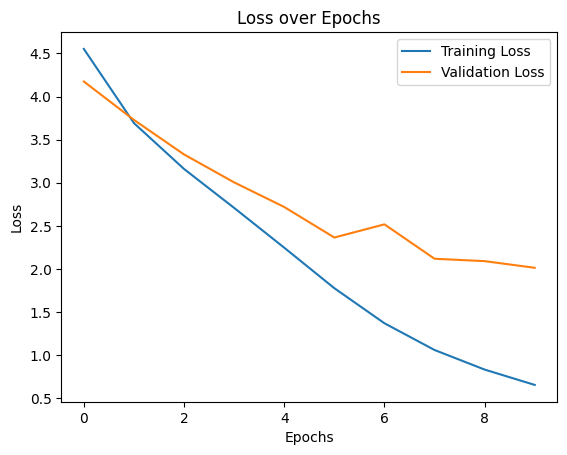

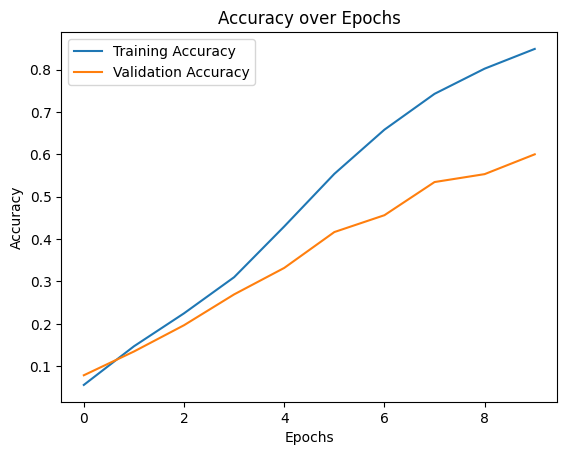

In [50]:
training_loss = [4.5520, 3.6921, 3.1599, 2.7084, 2.2469, 1.7772, 1.3706, 1.0605, 0.8333, 0.6554]
validation_loss = [4.1741, 3.7288, 3.3283, 3.0044, 2.7189, 2.3647, 2.5175, 2.1187, 2.0909, 2.0138]
training_acc = [0.0557, 0.1469, 0.2248, 0.3101, 0.4299, 0.5541, 0.6585, 0.7431, 0.8026, 0.8492]
validation_acc = [0.0785, 0.1346, 0.1967, 0.2695, 0.3320, 0.4167, 0.4565, 0.5348, 0.5535, 0.6003]

plt.figure()
plt.plot(training_loss, label="Training Loss")
plt.plot(validation_loss, label="Validation Loss")
plt.legend()
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Plot training and validation accuracy
plt.figure()
plt.plot(training_acc, label="Training Accuracy")
plt.plot(validation_acc, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()


# Fine-tuning YAMNet (pretrained on sound event detection)

In [34]:
import tensorflow_hub as hub
import tensorflow as tf
import librosa
import numpy as np
import os

# Load the YAMNet model
# Place the model and computation on the GPU
with tf.device('/GPU:0'):  # seems doesn't work
    yamnet = hub.load("https://tfhub.dev/google/yamnet/1")

# Define a feature extraction function
def extract_yamnet_features(file_path, yamnet_model):
    # Load audio file
    audio, sr = librosa.load(file_path, sr=16000)
    
    # Ensure audio is mono and normalized
    if audio.ndim > 1:
        audio = librosa.to_mono(audio)
    audio = tf.convert_to_tensor(audio, dtype=tf.float32)
    
    # Pass through YAMNet
    scores, embeddings, spectrogram = yamnet_model(audio)
    # print(scores.shape, embeddings.shape, spectrogram.shape)
    
    # Return the mean of the embeddings across time
    return embeddings.numpy().mean(axis=0)

# Example: Extract features for all files
def process_dataset(file_paths, yamnet_model):
    features = []
    for i, file in enumerate(file_paths):
        if i % 1000 == 0:
            print('Extracting feature for sample', i)
        features.append(extract_yamnet_features(file, yamnet_model))
    return np.array(features)

# Process training and validation data
X_train = process_dataset(train_files, yamnet)
X_val = process_dataset(val_files, yamnet)

# Ensure labels are numpy arrays
y_train = np.array(y_train_encoded)
y_val = np.array(y_val_encoded)

print("Training feature shape:", X_train.shape)
print("Validation feature shape:", X_val.shape)


Extracting feature for sample 0
Extracting feature for sample 1000
Extracting feature for sample 2000
Extracting feature for sample 3000
Extracting feature for sample 4000
Extracting feature for sample 5000
Extracting feature for sample 6000
Extracting feature for sample 7000
Extracting feature for sample 8000
Extracting feature for sample 9000
Extracting feature for sample 10000
Extracting feature for sample 11000
Extracting feature for sample 12000
Extracting feature for sample 13000
Extracting feature for sample 14000
Extracting feature for sample 15000
Extracting feature for sample 16000
Extracting feature for sample 17000
Extracting feature for sample 18000
Extracting feature for sample 19000
Extracting feature for sample 20000
Extracting feature for sample 21000
Extracting feature for sample 22000
Extracting feature for sample 23000
Extracting feature for sample 24000
Extracting feature for sample 25000
Extracting feature for sample 26000
Extracting feature for sample 27000
Extra

In [43]:
np.savez('yamnet_features.npz', X_train=X_train, X_val=X_val, y_train=y_train, y_val=y_val)

In [36]:
data = np.load('yamnet_features.npz')

X_train = data['X_train']
X_val = data['X_val']
y_train = data['y_train']
y_val = data['y_val']

In [52]:
print("Training feature shape:", X_train.shape)
print("Validation feature shape:", X_val.shape)
print("Training label shape:", y_train.shape)
print("Validation label shape:", y_val.shape)

Training feature shape: (114674, 1024)
Validation feature shape: (33968, 1024)
Training label shape: (114674,)
Validation label shape: (33968,)


### Sample 200 speakers

In [44]:
import numpy as np

# Sample the first 200 speakers
def sample_first_n_speakers(X, y, n=200):
    # Get unique speaker IDs and select the first `n`
    unique_speakers = np.unique(y)
    selected_speakers = unique_speakers[:n]
    
    # Filter the data for selected speakers
    mask = np.isin(y, selected_speakers)
    X_sampled = X[mask]
    y_sampled = y[mask]
    
    return X_sampled, y_sampled

# Apply sampling to training and validation sets
X_train_sampled, y_train_sampled = sample_first_n_speakers(X_train, y_train, n=200)
X_val_sampled, y_val_sampled = sample_first_n_speakers(X_val, y_val, n=200)

# Map labels to a range of 0 to n-1 to avoid label value errors
def remap_labels(y):
    unique_labels = np.unique(y)
    label_map = {old: new for new, old in enumerate(unique_labels)}
    y_remapped = np.array([label_map[label] for label in y])
    return y_remapped

y_train_sampled = remap_labels(y_train_sampled)
y_val_sampled = remap_labels(y_val_sampled)

# Print dataset shapes after sampling
print(f"X_train_sampled shape: {X_train_sampled.shape}")
print(f"y_train_sampled shape: {y_train_sampled.shape}")
print(f"X_val_sampled shape: {X_val_sampled.shape}")
print(f"y_val_sampled shape: {y_val_sampled.shape}")


X_train_sampled shape: (18385, 1024)
y_train_sampled shape: (18385,)
X_val_sampled shape: (5424, 1024)
y_val_sampled shape: (5424,)


In [48]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_sampled)
y_val_encoded = label_encoder.transform(y_val_sampled)

train_dataset = TensorDataset(torch.tensor(X_train_sampled, dtype=torch.float32), torch.tensor(y_train_encoded, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val_sampled, dtype=torch.float32), torch.tensor(y_val_encoded, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001, print_every=100):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Lists to store metrics for plotting
    training_loss_list = []
    training_accuracy_list = []
    validation_loss_list = []
    validation_accuracy_list = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for i, (X_batch, y_batch) in enumerate(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

            # Print metrics every n iterations
            if (i + 1) % print_every == 0:
                avg_loss = total_loss / (i + 1)
                accuracy = correct / total
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], "
                      f"Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

        # Store training metrics for this epoch
        training_loss_list.append(total_loss / len(train_loader))
        training_accuracy_list.append(correct / total)

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += y_batch.size(0)
                val_correct += (predicted == y_batch).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = val_correct / val_total
        validation_loss_list.append(avg_val_loss)
        validation_accuracy_list.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {training_loss_list[-1]:.4f}, "
              f"Training Accuracy: {training_accuracy_list[-1]:.4f}, "
              f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    return {
        "training_loss": training_loss_list,
        "training_accuracy": training_accuracy_list,
        "validation_loss": validation_loss_list,
        "validation_accuracy": validation_accuracy_list,
    }


Epoch [1/30], Step [100/575], Loss: 5.0976, Accuracy: 0.0394
Epoch [1/30], Step [200/575], Loss: 4.9320, Accuracy: 0.0569
Epoch [1/30], Step [300/575], Loss: 4.7692, Accuracy: 0.0751
Epoch [1/30], Step [400/575], Loss: 4.6275, Accuracy: 0.0896
Epoch [1/30], Step [500/575], Loss: 4.5070, Accuracy: 0.1008
Epoch [1/30], Training Loss: 4.4317, Training Accuracy: 0.1094, Validation Loss: 4.3891, Validation Accuracy: 0.0975
Epoch [2/30], Step [100/575], Loss: 3.8332, Accuracy: 0.1650
Epoch [2/30], Step [200/575], Loss: 3.7665, Accuracy: 0.1787
Epoch [2/30], Step [300/575], Loss: 3.7077, Accuracy: 0.1875
Epoch [2/30], Step [400/575], Loss: 3.6576, Accuracy: 0.1980
Epoch [2/30], Step [500/575], Loss: 3.6160, Accuracy: 0.2075
Epoch [2/30], Training Loss: 3.5897, Training Accuracy: 0.2128, Validation Loss: 4.1334, Validation Accuracy: 0.1250
Epoch [3/30], Step [100/575], Loss: 3.3257, Accuracy: 0.2519
Epoch [3/30], Step [200/575], Loss: 3.2949, Accuracy: 0.2536
Epoch [3/30], Step [300/575], Loss

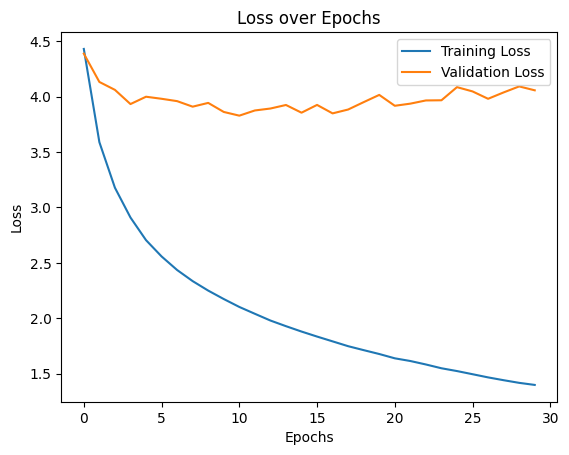

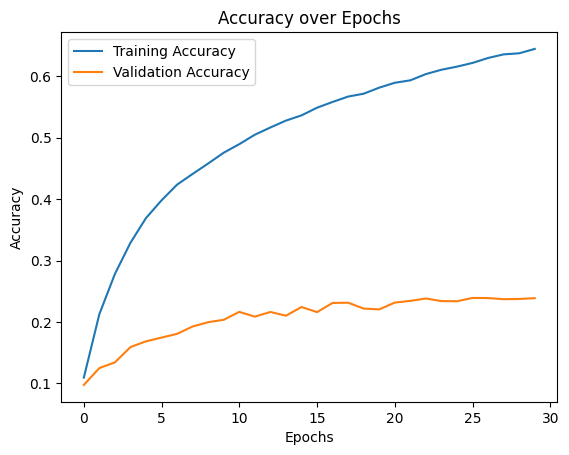

In [49]:
# Train the model and get metrics
model = SmallNet(input_size=1024, num_classes=200)
metrics = train_model(model, train_loader, val_loader, num_epochs=30, print_every=100)

plt.figure()
plt.plot(metrics["training_loss"], label="Training Loss")
plt.plot(metrics["validation_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Plot training and validation accuracy
plt.figure()
plt.plot(metrics["training_accuracy"], label="Training Accuracy")
plt.plot(metrics["validation_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()


Epoch [1/30], Step [100/575], Loss: 5.1404, Accuracy: 0.0341
Epoch [1/30], Step [200/575], Loss: 4.9186, Accuracy: 0.0547
Epoch [1/30], Step [300/575], Loss: 4.7199, Accuracy: 0.0715
Epoch [1/30], Step [400/575], Loss: 4.5638, Accuracy: 0.0851
Epoch [1/30], Step [500/575], Loss: 4.4321, Accuracy: 0.0984
Epoch [1/30], Training Loss: 4.3504, Training Accuracy: 0.1067, Validation Loss: 4.3385, Validation Accuracy: 0.0892
Epoch [2/30], Step [100/575], Loss: 3.6302, Accuracy: 0.1841
Epoch [2/30], Step [200/575], Loss: 3.5987, Accuracy: 0.1884
Epoch [2/30], Step [300/575], Loss: 3.5641, Accuracy: 0.1913
Epoch [2/30], Step [400/575], Loss: 3.5396, Accuracy: 0.1963
Epoch [2/30], Step [500/575], Loss: 3.5072, Accuracy: 0.2023
Epoch [2/30], Training Loss: 3.4744, Training Accuracy: 0.2088, Validation Loss: 4.2766, Validation Accuracy: 0.1143
Epoch [3/30], Step [100/575], Loss: 3.1988, Accuracy: 0.2416
Epoch [3/30], Step [200/575], Loss: 3.2113, Accuracy: 0.2489
Epoch [3/30], Step [300/575], Loss

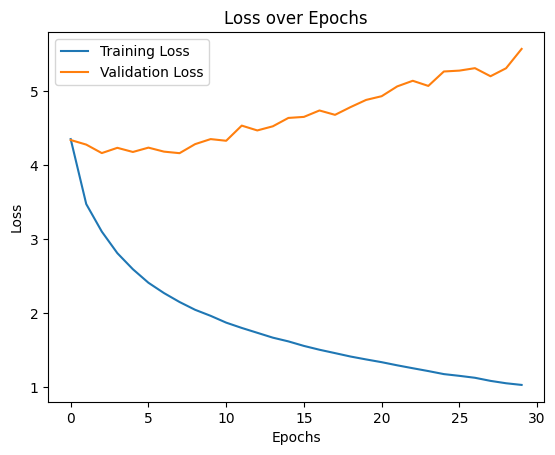

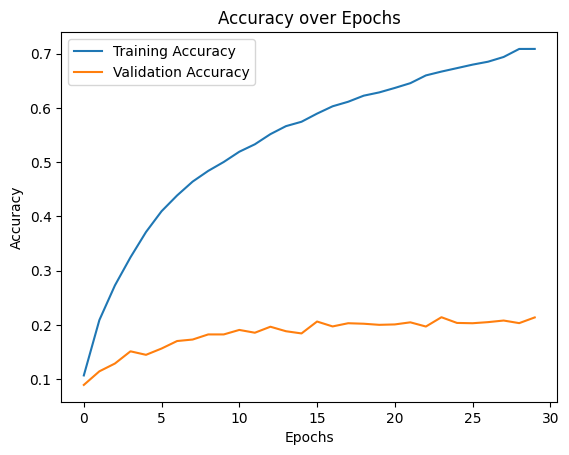

In [50]:
# Train the model and get metrics
model = MediumNet(input_size=1024, num_classes=200)
metrics = train_model(model, train_loader, val_loader, num_epochs=30, print_every=100)

plt.figure()
plt.plot(metrics["training_loss"], label="Training Loss")
plt.plot(metrics["validation_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Plot training and validation accuracy
plt.figure()
plt.plot(metrics["training_accuracy"], label="Training Accuracy")
plt.plot(metrics["validation_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()


Epoch [1/30], Step [100/575], Loss: 5.1230, Accuracy: 0.0288
Epoch [1/30], Step [200/575], Loss: 4.8762, Accuracy: 0.0530
Epoch [1/30], Step [300/575], Loss: 4.6920, Accuracy: 0.0659
Epoch [1/30], Step [400/575], Loss: 4.5635, Accuracy: 0.0748
Epoch [1/30], Step [500/575], Loss: 4.4712, Accuracy: 0.0832
Epoch [1/30], Training Loss: 4.4068, Training Accuracy: 0.0883, Validation Loss: 4.3512, Validation Accuracy: 0.0955
Epoch [2/30], Step [100/575], Loss: 3.8609, Accuracy: 0.1481
Epoch [2/30], Step [200/575], Loss: 3.8066, Accuracy: 0.1512
Epoch [2/30], Step [300/575], Loss: 3.7653, Accuracy: 0.1552
Epoch [2/30], Step [400/575], Loss: 3.7343, Accuracy: 0.1609
Epoch [2/30], Step [500/575], Loss: 3.6969, Accuracy: 0.1647
Epoch [2/30], Training Loss: 3.6742, Training Accuracy: 0.1678, Validation Loss: 4.2017, Validation Accuracy: 0.1053
Epoch [3/30], Step [100/575], Loss: 3.4267, Accuracy: 0.2084
Epoch [3/30], Step [200/575], Loss: 3.4363, Accuracy: 0.2033
Epoch [3/30], Step [300/575], Loss

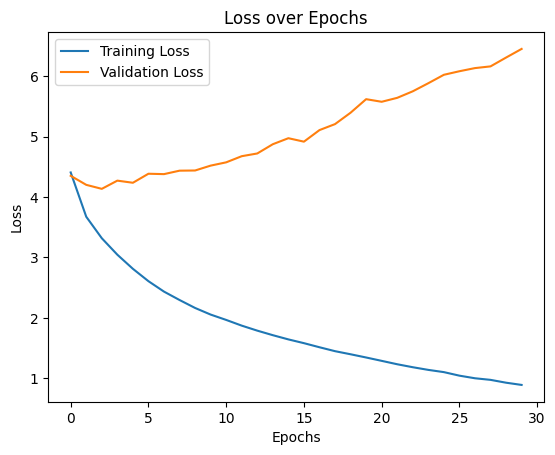

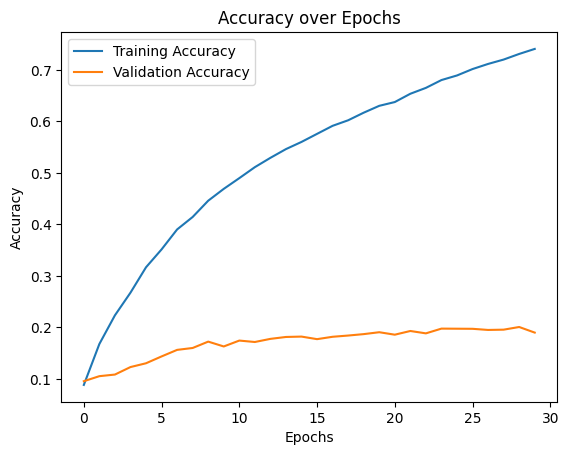

In [51]:
# Train the model and get metrics
model = LargeNet(input_size=1024, num_classes=200)
metrics = train_model(model, train_loader, val_loader, num_epochs=30, print_every=100)

plt.figure()
plt.plot(metrics["training_loss"], label="Training Loss")
plt.plot(metrics["validation_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Plot training and validation accuracy
plt.figure()
plt.plot(metrics["training_accuracy"], label="Training Accuracy")
plt.plot(metrics["validation_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()
